# Code Reference

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [9]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
import pickle
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [10]:
device = torch.device('cpu')

In [11]:
class hcp_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        subject_name = self.df.iloc[idx]['Subject']
        image_path ='../data/hcp2/'+str(subject_name)+'/T1w/T1w_acpc_dc_restore_brain.nii.gz'
        image = nib.load(image_path)
        image_array = image.get_fdata()
        
        #Normaliztion
        image_array = (image_array - image_array.mean()) / image_array.std()
        
        #label = self.df.loc[idx][['N','E','O','A','C']].values.astype(int)
        label = self.df.loc[idx][['N']].values[0].astype(int) # predict N
        
        
        sample = {'x': image_array[None,:], 'y': label}
        
        return sample

In [12]:
train_df_path = '../train_test.csv'
val_df_path = '../val_test.csv'
test_df_path = '../test.csv'
transformed_dataset = {'train': hcp_dataset(train_df_path, train = True),
                       'validate':hcp_dataset(val_df_path),
                       'test':hcp_dataset(test_df_path),}
bs = 1

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [13]:
sample = next(iter(dataloader['train']))['x']
sample.size()

torch.Size([1, 1, 260, 311, 260])

In [14]:
class CNN_3D(nn.Module):
    def __init__(self):
        super(CNN_3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 8, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool3d(kernel_size=(3,3,3), stride=(3,3,3))
        
        self.conv2 = nn.Conv3d(8, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool3d(kernel_size=(3,3,3), stride=(3,3,3))
        
        self.conv3 = nn.Conv3d(32, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.activation3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool3d(kernel_size=(3,3,3), stride=(3,3,3))
        
        self.conv4 = nn.Conv3d(64, 64, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm3d(64)
        self.activation4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool3d(kernel_size=(3,3,3), stride=(3,3,3))
        
        self.conv5 = nn.Conv3d(64, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm3d(64)
        self.activation5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool3d(kernel_size=(3,3,3), stride=(3,3,3))
        
        self.fc1 = nn.Linear(64,1000)
        self.fc2 = nn.Linear(1000,3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation3(x)
        x = self.maxpool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.activation4(x)
        x = self.maxpool4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.activation5(x)
        x = self.maxpool5(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
model = CNN_3D()
model = model.to(device)

In [15]:
output = model(sample.to(device,dtype=torch.float))

In [16]:
output.size()

torch.Size([1, 3])

In [17]:
state = torch.load('Model5_test1_CPU.pt')
model.load_state_dict(state)

<All keys matched successfully>

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, dataloader, phase = 'test'):   
    model.eval()
    y_test_label = []
    y_test = []
    y_score = []
    pre = []
    for data in dataloader[phase]:
        image = data['x'].to(device,dtype=torch.float)
        label = data['y'].to('cpu',dtype=torch.long)
        y_test_label = y_test_label+label.tolist()
        label = label_binarize(label, classes=[0, 1, 2])
        if y_test == []:
            y_test=label
        else:
            y_test = np.concatenate((y_test,label),axis = 0)
        output = model(image)
        #output = F.softmax(output,dim=1)
        output = output.to('cpu')
        if y_score == []:
            y_score=np.array(output.detach().numpy())
        else:
            y_score = np.concatenate((y_score,output.detach().numpy()),axis = 0)
    for i in y_score:
        pre.append(list(i).index(max(i)))
    return y_test_label,y_test,pre,y_score

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    #print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(-0.5, cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return None

## Test1

In [19]:
state = torch.load('Model5_test1_CPU.pt')
model.load_state_dict(state)

<All keys matched successfully>

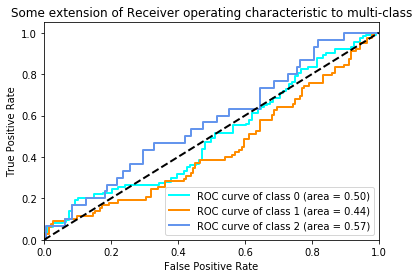

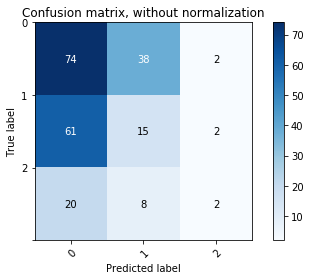

In [20]:
y_test_label,y_test,pre,y_score = evaluate_model(model, dataloader, phase = 'test')
ROC_curve(y_test,y_score)
classes = ['0','1','2']
plot_confusion_matrix(y_test_label, pre, classes)

## Test2

In [22]:
class hcp_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        subject_name = self.df.iloc[idx]['Subject']
        image_path ='../data/hcp2/'+str(subject_name)+'/T1w/T1w_acpc_dc_restore_brain.nii.gz'
        image = nib.load(image_path)
        image_array = image.get_fdata()
        
        #Normaliztion
        image_array = (image_array - image_array.mean()) / image_array.std()
        
        #label = self.df.loc[idx][['N','E','O','A','C']].values.astype(int)
        label = self.df.loc[idx][['E']].values[0].astype(int) # predict E
        
        
        sample = {'x': image_array[None,:], 'y': label}
        
        return sample

train_df_path = '../train_test.csv'
val_df_path = '../val_test.csv'
test_df_path = '../test.csv'
transformed_dataset = {'train': hcp_dataset(train_df_path, train = True),
                       'validate':hcp_dataset(val_df_path),
                       'test':hcp_dataset(test_df_path),}
bs = 1

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

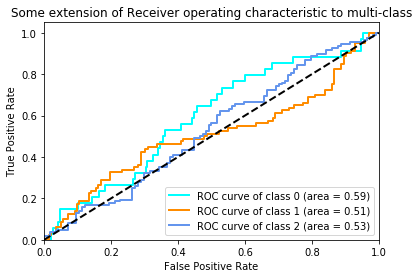

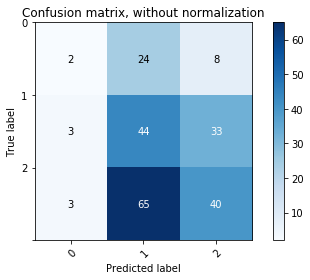

In [23]:
state = torch.load('Model5_test2_CPU.pt')
model.load_state_dict(state)
y_test_label,y_test,pre,y_score = evaluate_model(model, dataloader, phase = 'test')
ROC_curve(y_test,y_score)
classes = ['0','1','2']
plot_confusion_matrix(y_test_label, pre, classes)

## Test3

In [24]:
class hcp_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        subject_name = self.df.iloc[idx]['Subject']
        image_path ='../data/hcp2/'+str(subject_name)+'/T1w/T1w_acpc_dc_restore_brain.nii.gz'
        image = nib.load(image_path)
        image_array = image.get_fdata()
        
        #Normaliztion
        image_array = (image_array - image_array.mean()) / image_array.std()
        
        #label = self.df.loc[idx][['N','E','O','A','C']].values.astype(int)
        label = self.df.loc[idx][['O']].values[0].astype(int) # predict O
        
        
        sample = {'x': image_array[None,:], 'y': label}
        
        return sample

train_df_path = '../train_test.csv'
val_df_path = '../val_test.csv'
test_df_path = '../test.csv'
transformed_dataset = {'train': hcp_dataset(train_df_path, train = True),
                       'validate':hcp_dataset(val_df_path),
                       'test':hcp_dataset(test_df_path),}
bs = 1

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

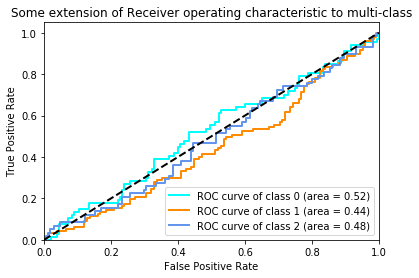

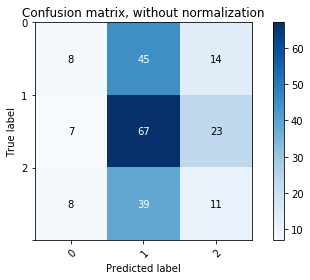

In [25]:
state = torch.load('Model5_test3_CPU.pt')
model.load_state_dict(state)
y_test_label,y_test,pre,y_score = evaluate_model(model, dataloader, phase = 'test')
ROC_curve(y_test,y_score)
classes = ['0','1','2']
plot_confusion_matrix(y_test_label, pre, classes)

## Test4

In [26]:
class hcp_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        subject_name = self.df.iloc[idx]['Subject']
        image_path ='../data/hcp2/'+str(subject_name)+'/T1w/T1w_acpc_dc_restore_brain.nii.gz'
        image = nib.load(image_path)
        image_array = image.get_fdata()
        
        #Normaliztion
        image_array = (image_array - image_array.mean()) / image_array.std()
        
        
        #label = self.df.loc[idx][['N','E','O','A','C']].values.astype(int)
        label = self.df.loc[idx][['A']].values[0].astype(int) # predict A
        
        
        sample = {'x': image_array[None,:], 'y': label}
        
        return sample

train_df_path = '../train_test.csv'
val_df_path = '../val_test.csv'
test_df_path = '../test.csv'
transformed_dataset = {'train': hcp_dataset(train_df_path, train = True),
                       'validate':hcp_dataset(val_df_path),
                       'test':hcp_dataset(test_df_path),}
bs = 1

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

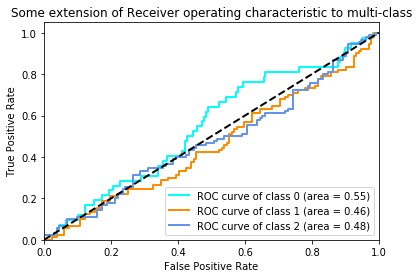

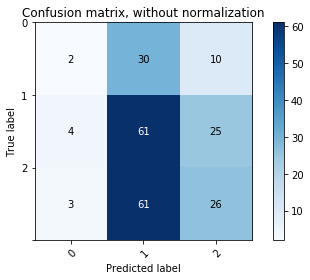

In [27]:
state = torch.load('Model5_test4_CPU.pt')
model.load_state_dict(state)
y_test_label,y_test,pre,y_score = evaluate_model(model, dataloader, phase = 'test')
ROC_curve(y_test,y_score)
classes = ['0','1','2']
plot_confusion_matrix(y_test_label, pre, classes)

## Test5

In [28]:
class hcp_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        subject_name = self.df.iloc[idx]['Subject']
        image_path ='../data/hcp2/'+str(subject_name)+'/T1w/T1w_acpc_dc_restore_brain.nii.gz'
        image = nib.load(image_path)
        image_array = image.get_fdata()
        
        #Normaliztion
        image_array = (image_array - image_array.mean()) / image_array.std()
        
        #label = self.df.loc[idx][['N','E','O','A','C']].values.astype(int)
        label = self.df.loc[idx][['C']].values[0].astype(int) # predict C
        
        
        sample = {'x': image_array[None,:], 'y': label}
        
        return sample

train_df_path = '../train_test.csv'
val_df_path = '../val_test.csv'
test_df_path = '../test.csv'
transformed_dataset = {'train': hcp_dataset(train_df_path, train = True),
                       'validate':hcp_dataset(val_df_path),
                       'test':hcp_dataset(test_df_path),}
bs = 1

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

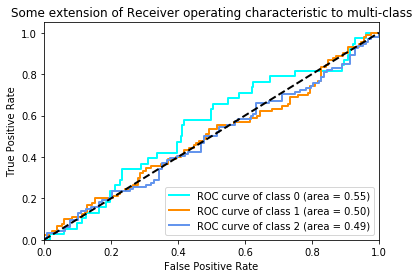

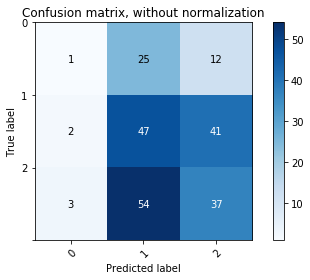

In [29]:
state = torch.load('Model5_test5_CPU.pt')
model.load_state_dict(state)
y_test_label,y_test,pre,y_score = evaluate_model(model, dataloader, phase = 'test')
ROC_curve(y_test,y_score)
classes = ['0','1','2']
plot_confusion_matrix(y_test_label, pre, classes)